In [1]:
import pickle
import pandas as pd
import os
import yfinance as yf
from utils.plot_decision_trees import plot_tree


from utils.pre_process_data import get_data
from math import ceil
from utils.units import Volume, Dollar
from deap import gp, creator, base, tools
from deap.gp import Terminal
from operator import or_, and_, gt
from fitness_functions import *
from utils.plot_decision_trees import plot_tree
from utils.save_info import save_results
from genetic_functions.cx_functions import cxSubTree
from genetic_functions.mut_functions import mutation_half, mutBranch
from genetic_functions.genetic_program import GPAlgo
import matplotlib.pyplot as plt
import pendulum


In [2]:
eth_ts = get_data(
        ticker = "ETH-USD", 
        start='2016-01-01', 
        end='2024-06-30',
        ma_lags = 50,
        lag_lags = 50,
        pers_col_num = 10
    )

c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final p

In [3]:
df = get_data()
df_train= df.iloc[ : ceil(len(df)*0.7)]
df_test= df.iloc[ceil(len(df)*0.7) : ]

arg_names = list(df_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]


pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
        #Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_dol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}
pset.renameArguments(**arg_dol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

# --- GP OPERATORS ----

creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)
toolbox.register("evaluate", fitness_function, df=df_train, pset=pset)

toolbox.register("mate",       cxSubTree)
toolbox.register("select",     tools.selRanked) 
toolbox.register("mutate",     mutation_half, pset=pset)

hof   = tools.HallOfFame(maxsize=50)

#STATS:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final p

In [4]:
population = []
base_dir = r"C:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies"
run_list = os.listdir("results_run3")
for dir in run_list:
    if os.path.isdir(rf"{base_dir}\results_run3\{dir}") and "run" in dir:
        with open(rf"{base_dir}\results_run3\{dir}\hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            try:
                hof = pickle.load(file)
                for i in range(4):
                    population.append(hof[i])
            except:
                print(dir," File not found.")

# ADD IN GEN 2 results:
run_list = os.listdir("results_run3_gen2")
for dir in run_list:
    if os.path.isdir(rf"{base_dir}\results_run3_gen2\{dir}") and "run" in dir:
        with open(rf"{base_dir}\results_run3_gen2\{dir}\hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            try:
                hof = pickle.load(file)
                for i in range(5):
                    population.append(hof[i])
            except:
                print(dir," File not found.")

In [5]:
# with open(r"C:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\results_run2_gen3\start_pop.pkl", 'wb') as file:
#     # Serialize the object and write it to the file
#     pickle.dump(best_sol_pop, file)

In [6]:
len(population)

101

In [7]:
best_sol_pop = []
for ind in population:
    if best_sol_pop == []:
        best_sol_pop.append(ind)
    elif [i.fitness.values[0] for i in best_sol_pop].count(ind.fitness.values[0])==0:
        best_sol_pop.append(ind)
len(best_sol_pop)


96

In [8]:
best_sol_pop.sort(key = lambda x : x.fitness.values, reverse=True)
print(len(best_sol_pop))

96


In [9]:
per_list = []
for k in best_sol_pop:
    per = [i.split("_")[-1] for i in str(k).split("'") if "percentage" in i]
    if per:
        per_list.append(per)
print(set([i[0] for i in per_list]))

{'37', '60', '68', '57'}


In [10]:

# with open(rf"\home\khann\masters\results\run2_2024-08-09_09-20\logbook.pkl", 'rb') as file:
# # Serialize the object and write it to the file
#     logbook = pickle.load(file)

# with open(rf"\home\khann\masters\results\run2_2024-08-09_09-20\hof.pkl", 'rb') as file:
# # Serialize the object and write it to the file
#     hof2 = pickle.load(file)

In [11]:
# max_lst = []
# for i in logbook:
#     max_lst.append(i['max'])
# x=range(0,len(max_lst))

In [12]:
bs = best_sol_pop[:20]
lst_bsp_test = []
lst_bsp_train = []

for i in bs:
    lst_bsp_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])
    lst_bsp_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])
    

In [13]:
print(df_train['Open'].iloc[-1])
print(df_train['Open'].iloc[0])

df_train['Open'].iloc[-1]-df_train['Open'].iloc[0]

50428.69140625
422.7300109863281


np.float64(50005.96139526367)

In [14]:
[(i.fitness.values)[0] for i in best_sol_pop]

[191725.28127442498,
 187209.37665382808,
 175976.6652828827,
 165785.62153243626,
 161741.58411272374,
 159266.16826559114,
 156436.2306094717,
 156292.3301083572,
 152366.28365862454,
 149647.43966894888,
 149141.08281634928,
 148046.19282675302,
 147916.67737716375,
 146944.20206860453,
 146612.8070024422,
 144011.23884550776,
 143684.53998150802,
 140801.66902546064,
 139270.6001572881,
 137266.90159031947,
 136197.0010723603,
 135943.88991825614,
 135573.44802044609,
 135388.07516267605,
 135218.2308442953,
 135133.3051603483,
 134293.6147558985,
 133746.91954285704,
 133064.19514399316,
 132964.59247602377,
 132141.36510991486,
 131482.62634637527,
 131112.0640046085,
 130679.72065084892,
 129824.37566490467,
 129563.19962438551,
 129496.44003191129,
 128985.19196058076,
 128537.01156997682,
 128354.61353866103,
 126096.38780275517,
 125411.75684585246,
 125074.34938075209,
 124938.38484154781,
 124625.79569896529,
 124517.92063666253,
 124489.43423120436,
 124038.53531104197,
 1

In [15]:
len(best_sol_pop)

96

Text(0, 0.5, 'Fitness Value')

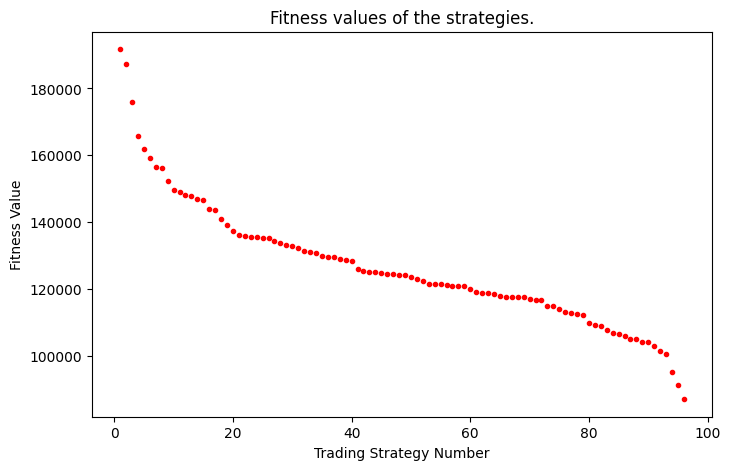

In [16]:
fitness_plot = best_sol_pop
plt.figure(figsize = (8,5))
plt.plot(range(1,len(fitness_plot)+1),[(i.fitness.values)[0] for i in fitness_plot],'r.')
plt.title("Fitness values of the strategies.")
plt.xlabel("Trading Strategy Number")
plt.ylabel("Fitness Value")

Text(0, 0.5, '$')

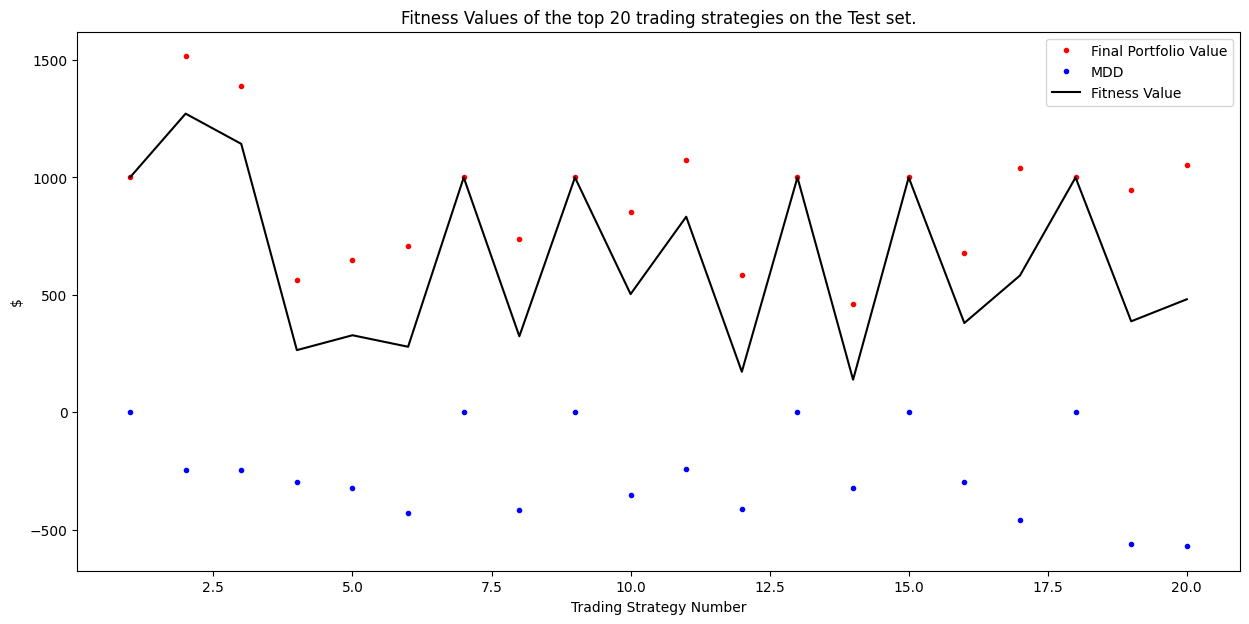

In [17]:
plt.figure(figsize=(15,7))
plt.title("Fitness Values of the top 20 trading strategies on the Test set.")
plt.plot(range(1,len(bs)+1),[i[0] for i in lst_bsp_test],'r.', label = "Final Portfolio Value")
plt.plot(range(1,len(bs)+1),[i[1] for i in lst_bsp_test],'b.', label='MDD')
plt.plot(range(1,len(bs)+1),[i[0]+i[1]  for i in lst_bsp_test],'k', label="Fitness Value")
plt.legend()
plt.xlabel("Trading Strategy Number")
plt.ylabel("$")

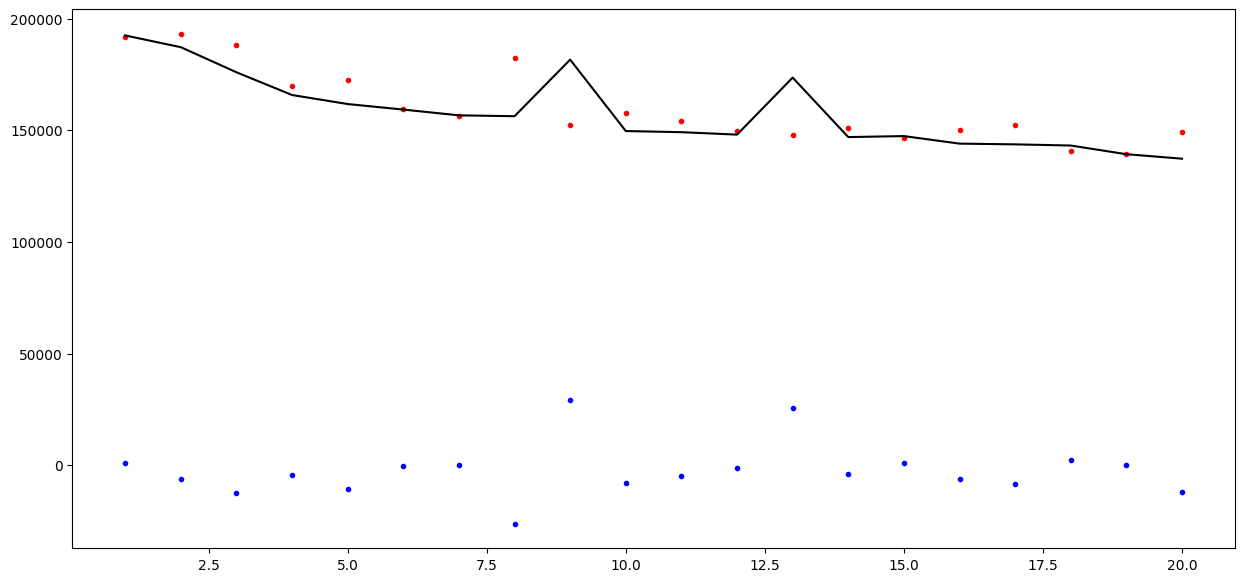

In [18]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(bs)+1),[i[0] for i in lst_bsp_train],'r.')
plt.plot(range(1,len(bs)+1),[i[1] for i in lst_bsp_train],'b.')
plt.plot(range(1,len(bs)+1),[i[0]+i[1]  for i in lst_bsp_train],'k')

In [19]:
def get_macd_value(df, val = 1000 , tc = 0.01):
    val_ts=[val]
    long=False

    # Add the required columns to the DF:
    df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
    df['ema26'] = df['Open'].ewm(span=26, adjust = False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['signal_line'] = df['macd'].ewm(span = 9, adjust=False).mean()
    
    df['macd_above'] = (df['macd'] - df['signal_line'])>0
    df['macd_above_lagged'] = df['macd_above'] .shift(1)

    #Impliment the trading strategy:
    for cnt, row in enumerate(df[['Open','macd_above','macd_above_lagged']].iterrows()):
        if (row[1]['macd_above']==True)  and (row[1]['macd_above_lagged']==False) and long==False:
            shares = ((1-tc)*val)/row[1]['Open']
            long=True
        elif (row[1]['macd_above']==False)  and (row[1]['macd_above_lagged']==True) and long==True:
            val = (1-tc)*shares*row[1]['Open']
            val_ts.append(val)
            long=False
        if cnt == len(df) and long:
            val = shares*row[1]['Open']
            val_ts.append(val)
    return val, val_ts

macd_test_val, macd_test_val_ts = get_macd_value(df = df_test)
macd_train_val, macd_train_val_ts = get_macd_value(df = df_train)

C:\Users\khann\AppData\Local\Temp\ipykernel_21448\2507065365.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_21448\2507065365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_21448\2507065365.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [20]:
[i.fitness.values for i in best_sol_pop][:20]

[(191725.28127442498,),
 (187209.37665382808,),
 (175976.6652828827,),
 (165785.62153243626,),
 (161741.58411272374,),
 (159266.16826559114,),
 (156436.2306094717,),
 (156292.3301083572,),
 (152366.28365862454,),
 (149647.43966894888,),
 (149141.08281634928,),
 (148046.19282675302,),
 (147916.67737716375,),
 (146944.20206860453,),
 (146612.8070024422,),
 (144011.23884550776,),
 (143684.53998150802,),
 (140801.66902546064,),
 (139270.6001572881,),
 (137266.90159031947,)]

In [21]:
tc = 0.01
#Test data
test_df = pd.DataFrame(columns=["Buy and Hold","Evolved Trading Strategy","MACD Trading Strategy"])
for ind,bs in enumerate(best_sol_pop):
    test_results = {
        "Buy and Hold":(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2,
        "Evolved Trading Strategy":trading_strat(individual = bs, df=df_test,pset=pset)[0],
        "MACD Trading Strategy": macd_test_val,
    }
    test_df.loc[ind] = test_results

<Axes: title={'center': 'Performance of the trading strategies on the test dataset.'}, xlabel='Stratgy number', ylabel='Final portfolio value'>

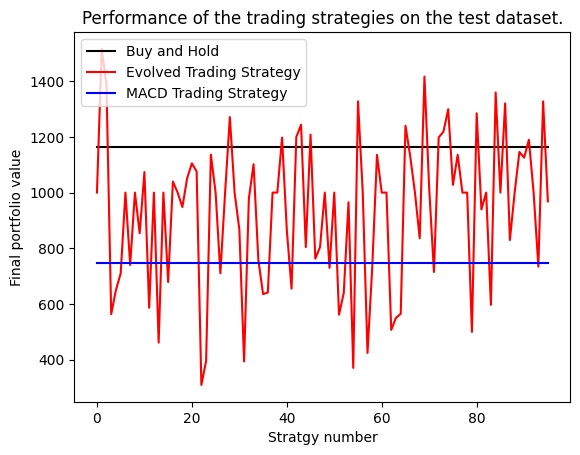

In [22]:
test_df.plot(
    title = "Performance of the trading strategies on the test dataset.",
    xlabel = "Stratgy number", 
    ylabel = "Final portfolio value",
    color = ["black","red","blue"])

<Axes: title={'center': 'Performance of the trading strategies on the testing dataset.'}, xlabel='Stratgy number', ylabel='Final portfolio value'>

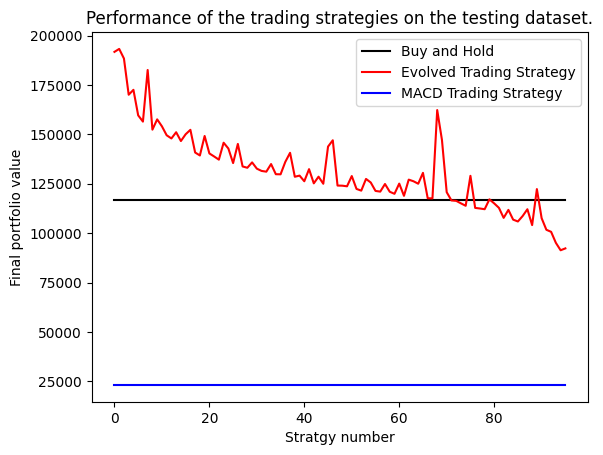

In [23]:
tc = 0.01
#Train data
train_df = pd.DataFrame(columns=["Buy and Hold","Evolved Trading Strategy","MACD Trading Strategy"])
for ind,bs in enumerate(best_sol_pop):
    train_results = {
        "Buy and Hold":(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2,
        "Evolved Trading Strategy":trading_strat(individual = bs, df=df_train,pset=pset)[0],
        "MACD Trading Strategy": macd_train_val
    }
    train_df.loc[ind] = train_results
train_df.plot(
    title = "Performance of the trading strategies on the testing dataset.",
    xlabel = "Stratgy number", 
    ylabel = "Final portfolio value",
    color = ["black","red","blue"]
    )

<Axes: xlabel='Date'>

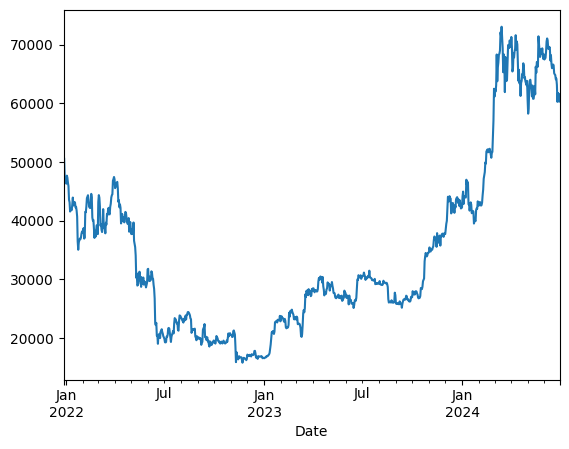

In [24]:
df_test['Open'].plot()

In [25]:
# DEFINE BUY-AND-HOLD:
def buy_and_hold(df,strat):
    val, mdd, ts_val, trade_rows = trading_strat(individual =strat, df=df,pset=pset, ret_trade_row=True)
    bh_val_ts = [1000]
    shares = 1000/df.iloc[0]['Open']
    for ind, row in enumerate(trade_rows):
        if ind!= len(trade_rows)-1:
            bh_val_ts.append(shares*df.loc[row[0]]['Open']*(1-tc)**2)
        else:
            bh_val_ts.append(shares*df.iloc[-1]['Open']*(1-tc)**2)
    return bh_val_ts


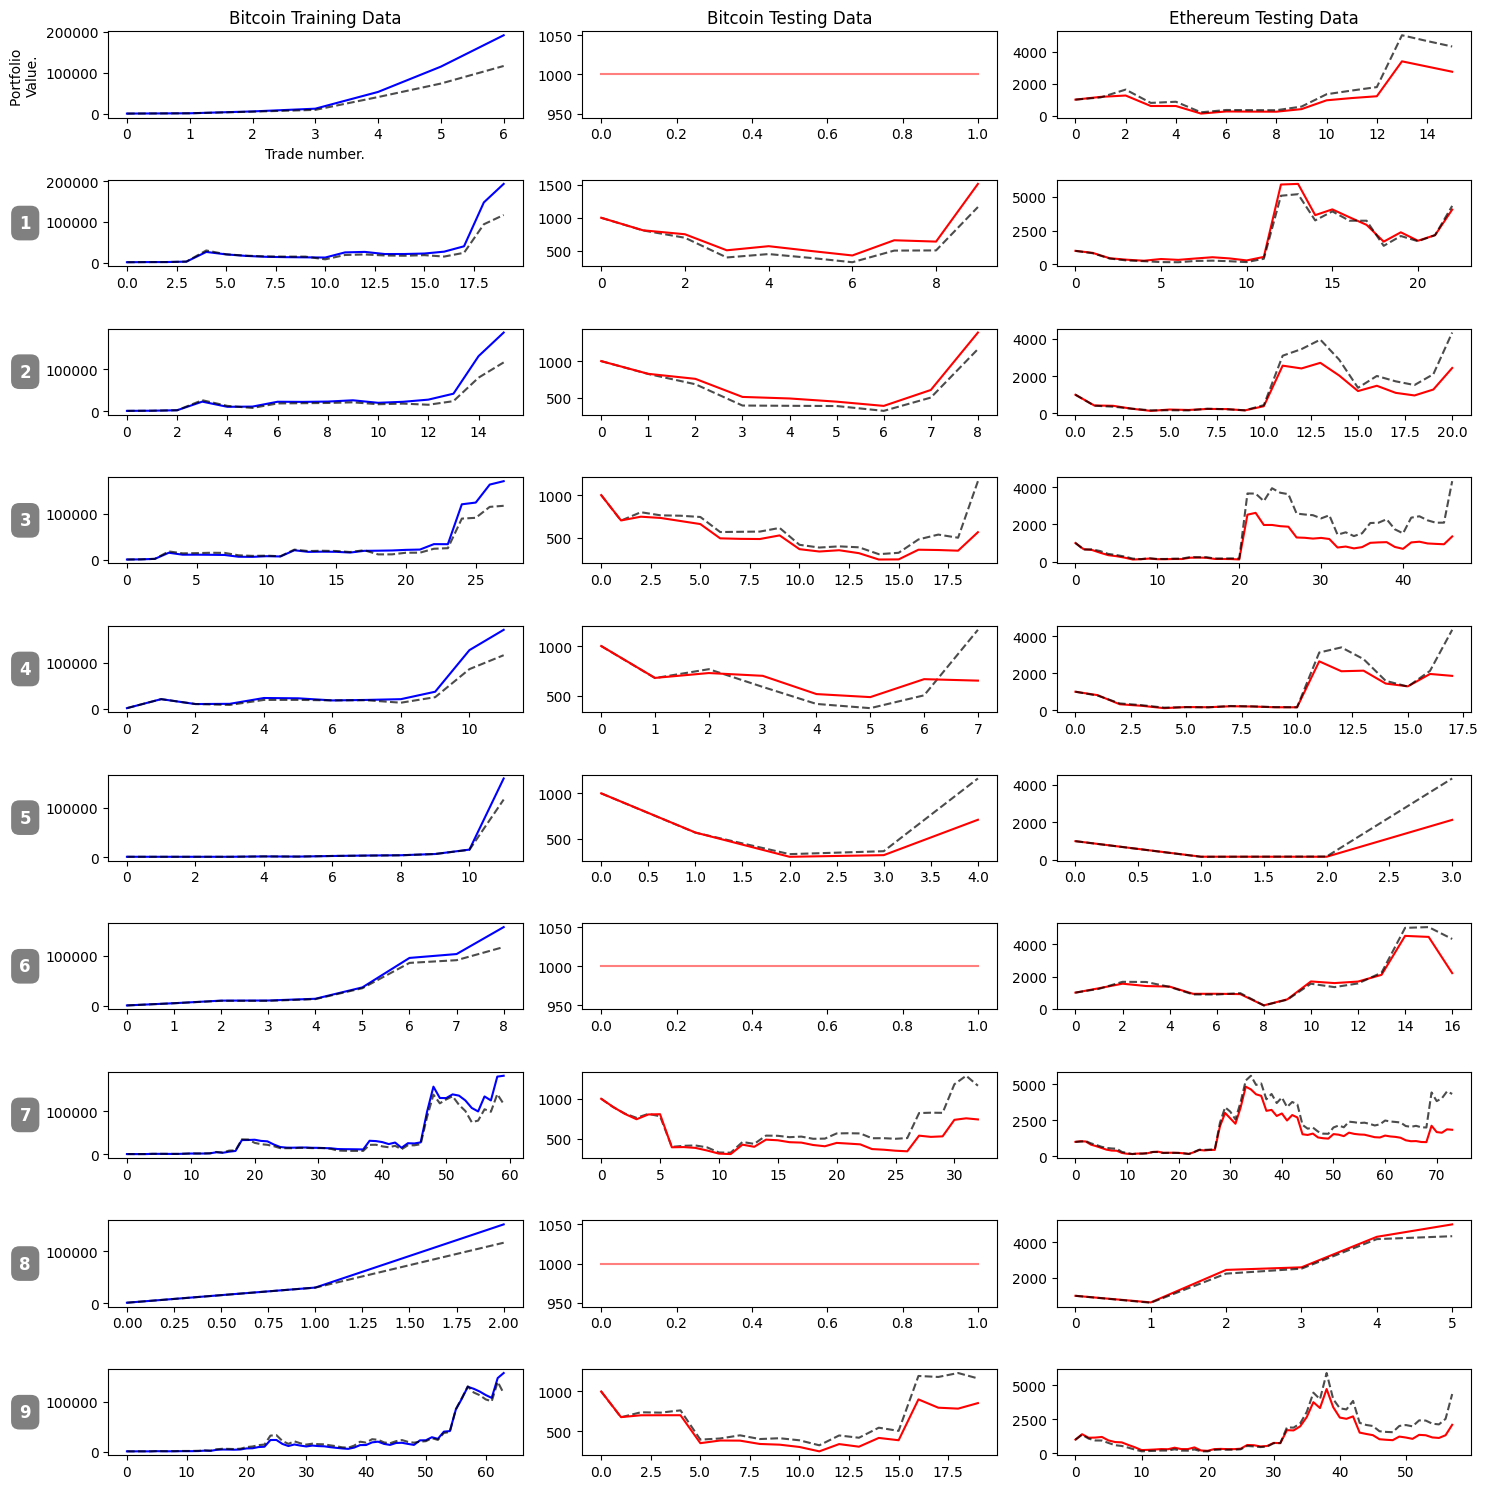

In [26]:
fig, ax = plt.subplots(ncols = 3, nrows = 10, figsize = (15,15))
ax[0,0].title.set_text("Bitcoin Training Data")
ax[0,0].set_ylabel("Portfolio \nValue.")
ax[0,0].set_xlabel("Trade number.")
ax[0,1].title.set_text("Bitcoin Testing Data")
ax[0,2].title.set_text("Ethereum Testing Data")

#---buy and hold ----
train_bs_end=[]
tc=0.01
train_bah = [1000,(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2]
test_bah = [1000,(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2]
eth_bah = [1000,(1000/eth_ts.iloc[0]['Open'])*eth_ts.iloc[-1]['Open']*(1-tc)**2]

for ind in range(10):
    train_ts = trading_strat(individual = best_sol_pop[ind], df=df_train,pset=pset)[2]
    test_ts = trading_strat(individual = best_sol_pop[ind], df=df_test,pset=pset)[2]
    eth_trade_ts = trading_strat(individual = best_sol_pop[ind], df=eth_ts,pset=pset)[2]

    train_bh_ts = buy_and_hold(df=df_train ,strat = best_sol_pop[ind])
    train_bs_end.append(train_bh_ts[-1])
    test_bh_ts = buy_and_hold(df=df_test ,strat = best_sol_pop[ind])
    eth_bh_ts = buy_and_hold(df=eth_ts ,strat = best_sol_pop[ind])

    # ax[ind,0].scatter([0,len(train_ts)-1],train_bah,c='k')
    ax[ind,0].plot(range(len(train_ts)),train_ts,color='b')
    ax[ind,0].plot(range(len(train_bh_ts)), train_bh_ts,color='k',alpha=0.7, linestyle='dashed')

    

    if ind!=0:
        ax[ind,0].text(-0.2, 0.5, f"{ind}", va='center', ha='center', transform=ax[ind,0].transAxes,fontsize=12, color='white', fontweight='bold',
                        bbox=dict(facecolor='grey', edgecolor='none', boxstyle='round,pad=0.5'))
    
    if len(test_ts)>1:
        ax[ind,1].plot(range(len(test_bh_ts)), test_bh_ts,color='k',alpha=0.7, linestyle='dashed')
        ax[ind,1].plot(range(len(test_ts)),test_ts,color='r')
    else:
        ax[ind,1].plot([0,1],[1000,1000],color='r', alpha=0.5)

    ax[ind,2].plot(range(len(eth_trade_ts)),eth_trade_ts, color='r')
    ax[ind,2].plot(range(len(eth_bh_ts)), eth_bh_ts,color='k',alpha=0.7, linestyle='dashed')

plt.tight_layout()


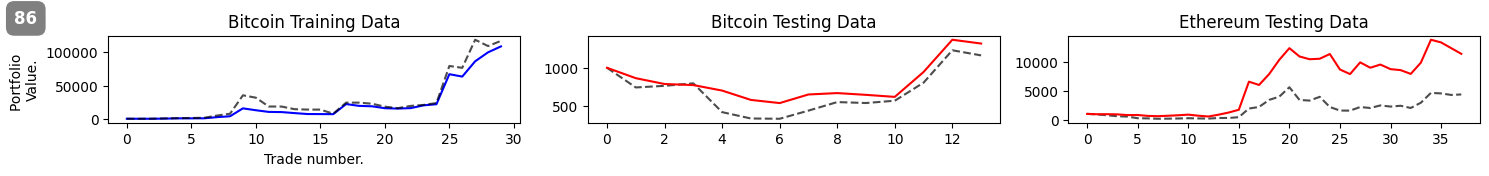

In [27]:
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (15,2))
ax[0].title.set_text("Bitcoin Training Data")
ax[0].set_ylabel("Portfolio \nValue.")
ax[0].set_xlabel("Trade number.")
ax[1].title.set_text("Bitcoin Testing Data")
ax[2].title.set_text("Ethereum Testing Data")
#STrat #86
ind= 0
train_ts = trading_strat(individual = best_sol_pop[86], df=df_train,pset=pset)[2]
test_ts = trading_strat(individual = best_sol_pop[86], df=df_test,pset=pset)[2]
eth_trade_ts = trading_strat(individual = best_sol_pop[86], df=eth_ts,pset=pset)[2]

train_bh_ts = buy_and_hold(df=df_train ,strat = best_sol_pop[86])
test_bh_ts = buy_and_hold(df=df_test ,strat = best_sol_pop[86])
eth_bh_ts = buy_and_hold(df=eth_ts ,strat = best_sol_pop[86])

ax[0].plot(range(len(train_ts)),train_ts,color='b')
ax[0].plot(range(len(train_bh_ts)), train_bh_ts,color='k',alpha=0.7, linestyle='dashed')

ax[0].text(-0.2, 1.2, "86", va='center', ha='center', transform=ax[0].transAxes,fontsize=12, color='white', fontweight='bold',
                        bbox=dict(facecolor='grey', edgecolor='none', boxstyle='round,pad=0.5'))
    

if len(test_ts)>1:
    ax[1].plot(range(len(test_bh_ts)), test_bh_ts,color='k',alpha=0.7, linestyle='dashed')
    ax[1].plot(range(len(test_ts)),test_ts,color='r')
else:
    ax[1].plot([0,1],[1000,1000],color='r', alpha=0.5)

ax[2].plot(range(len(eth_bh_ts)), eth_bh_ts,color='k',alpha=0.7, linestyle='dashed')
ax[2].plot(range(len(eth_trade_ts)),eth_trade_ts, color='r')

plt.tight_layout()

C:\Users\khann\AppData\Local\Temp\ipykernel_21448\2507065365.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_21448\2507065365.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ema26'] = df['Open'].ewm(span=26, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_21448\2507065365.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

<Axes: title={'center': 'Performance of the trading strategies on the Ethereum dataset.'}, xlabel='Stratgy number', ylabel='Final portfolio value'>

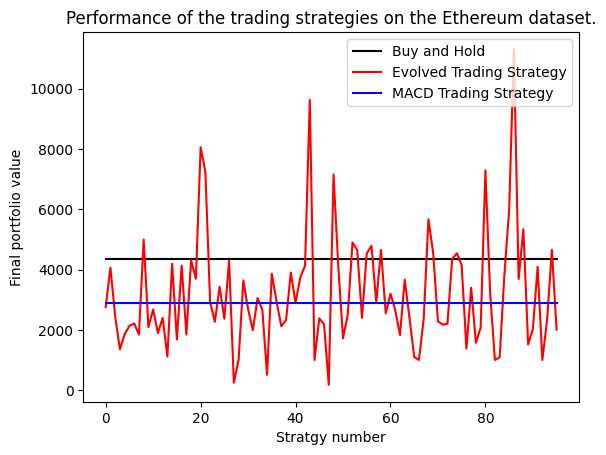

In [28]:
tc = 0.01
macd_eth_val, macd_eth_val_ts = get_macd_value(df = eth_ts)

#ETH data
eth_df = pd.DataFrame(columns=["Buy and Hold","Evolved Trading Strategy","MACD Trading Strategy"])
for ind,bs in enumerate(best_sol_pop):
    train_results = {
        "Buy and Hold":(1000/eth_ts.iloc[0]['Open'])*eth_ts.iloc[-1]['Open']*(1-tc)**2,
        "Evolved Trading Strategy":trading_strat(individual = bs, df=eth_ts,pset=pset)[0],
        "MACD Trading Strategy": macd_eth_val
    }
    eth_df.loc[ind] = train_results
eth_df.plot(
    title = "Performance of the trading strategies on the Ethereum dataset.",
    xlabel = "Stratgy number", 
    ylabel = "Final portfolio value",
    color = ["black","red","blue"]
    )

In [29]:
res_table = pd.DataFrame(columns = ["Trading Strategy","Bitcoin test", "Bitcoin train", "Ethereum"])
table_list = [
    {"Trading Strategy":"Buy-and-Hold","Bitcoin train": train_df['Buy and Hold'].iloc[0] , "Bitcoin test":test_df['Buy and Hold'].iloc[0],"Ethereum":eth_df['Buy and Hold'].iloc[0]},
    {"Trading Strategy":"MACD Trading Strategy","Bitcoin train":train_df['MACD Trading Strategy'].iloc[0], "Bitcoin test": test_df['MACD Trading Strategy'].iloc[0],"Ethereum":eth_df['MACD Trading Strategy'].iloc[0]}
    ]
iterate_list = list(range(0,10))
iterate_list.append(86)
for i in iterate_list:
    table_list.append({
        "Trading Strategy":f"Evolve strategy {i}",
        "Bitcoin train":train_df["Evolved Trading Strategy"].iloc[i], 
        "Bitcoin test": test_df["Evolved Trading Strategy"].iloc[i],
        "Ethereum":eth_df["Evolved Trading Strategy"].iloc[i]
        })
res_table = pd.DataFrame(table_list)
res_table.set_index("Trading Strategy", inplace = True)
res_table
res_table.to_csv("Overal_result_table.csv")

In [30]:
list(range(0,10)).append(86)

In [31]:
test_df.head()

,Buy and Hold,Evolved Trading Strategy,MACD Trading Strategy
0,1163.710097,1000.000000,747.607478
1,1163.710097,1516.159471,747.607478
2,1163.710097,1389.101144,747.607478
3,1163.710097,563.143925,747.607478
4,1163.710097,650.243321,747.607478


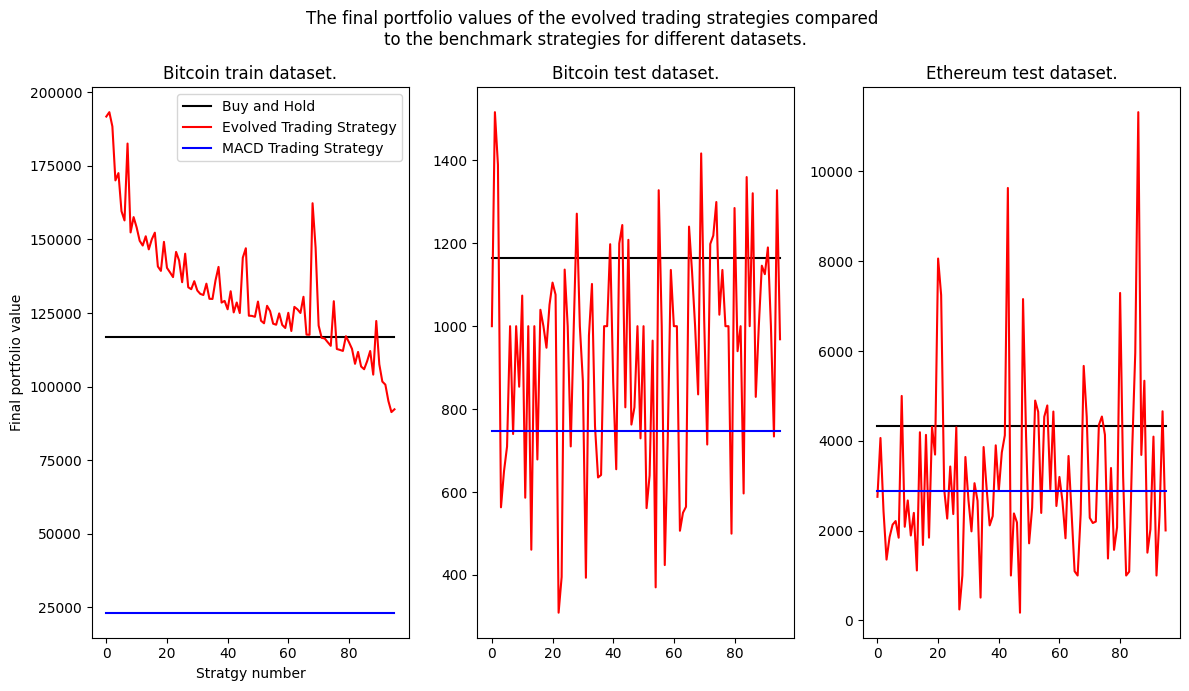

In [32]:
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(12,7))
plt.suptitle("The final portfolio values of the evolved trading strategies compared \nto the benchmark strategies for different datasets.")
train_df.plot(title = "Bitcoin train dataset.",xlabel = "Stratgy number", ylabel = "Final portfolio value", ax=ax[0], color=["black","red","blue"])
test_df.plot(title = "Bitcoin test dataset.", ax = ax[1], color=["black","red","blue"],legend=False)
eth_df.plot(title = "Ethereum test dataset.", ax = ax[2], color=["black","red","blue"],legend=False)
fig.subplots_adjust(top=0.83)
plt.tight_layout()

In [33]:
eth_df[eth_df['Evolved Trading Strategy'] == eth_df['Evolved Trading Strategy'].max()]

,Buy and Hold,Evolved Trading Strategy,MACD Trading Strategy
86,4338.124866,11320.91535,2876.450487


In [34]:
best_solution = best_sol_pop[0]
tc = 0.01
print("TEST")
print("MACD: ", macd_test_val)
print("Buy and hold:",(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_test))
print("strat value :",trading_strat(individual = best_solution, df=df_test,pset=pset)[0],'\n')

TEST
MACD:  747.6074778499653
Buy and hold: 1163.7100970760914
mtv         : 177218.81839494675
strat value : 1000 



In [35]:
tc = 0.01
print("TRAIN")
print("MACD: ", macd_train_val)
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_train))
print("strat value :",trading_strat(individual = best_solution, df=df_train,pset=pset)[0],'\n')

TRAIN
MACD:  23212.344970184193
Buy and hold: 116918.97703677377
mtv         : 1950319080593.2593
strat value : 191725.28127442498 



In [36]:
print("TRAIN")
print("MACD: ", macd_train_val)
print("Buy and hold:",(1000/eth_ts.iloc[0]['Open'])*eth_ts.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(eth_ts))
print("strat value :",trading_strat(individual = best_solution, df=eth_ts,pset=pset)[0],'\n')

TRAIN
MACD:  23212.344970184193
Buy and hold: 4338.1248657593005
mtv         : 625432336014882.5
strat value : 2753.2454282125204 



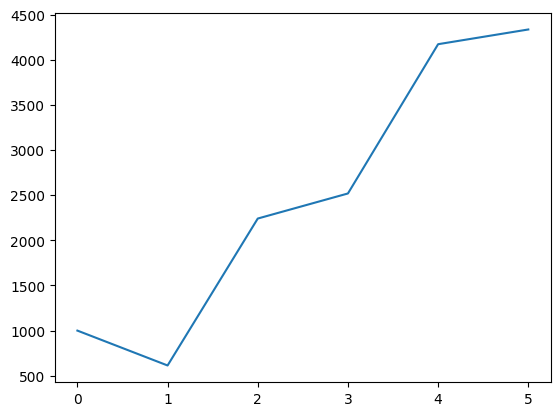

In [37]:

eth_bh_ts = buy_and_hold(df=eth_ts ,strat = best_sol_pop[8])
plt.plot(range(len(eth_bh_ts)), eth_bh_ts)

In [38]:
plt.figure(1)
plt.plot(range(len(ts_val)), ts_val,'k')
plt.plot(range(len(eth_bh_ts)), eth_bh_ts)

NameError: name 'ts_val' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)


Buy and hold: 116918.97703677377


In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')


plt.title("test data")

NameError: name 'hof2' is not defined

<Figure size 1500x700 with 0 Axes>

In [ ]:
[i[0]+i[1]  for i in lst_hof_test]

NameError: name 'lst_hof_test' is not defined

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]-i[1] for i in lst_hof_train],'k.')


plt.title("train data")
print([i[0]-i[1] for i in lst_hof_train])

NameError: name 'hof2' is not defined

<Figure size 1500x700 with 0 Axes>

In [ ]:
with open(rf"\home\khann\masters\results_run2\run_2024-08-10_02-20\hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '\\home\\khann\\masters\\results_run2\\run_2024-08-10_02-20\\hof.pkl'

In [39]:
lst_hof_test = []
for i in hof.items:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof.items:
    lst_hof_train.append(trading_strat(individual = i, df=df_train,pset=pset)[:2])

KeyboardInterrupt: 

In [ ]:
lst_hof_test

[(1000, 0),
 (1516.1594710913091, -244.51426032736845),
 (1389.1011438609512, -246.14538549855047),
 (563.1439254009194, -298.4619985256718),
 (650.243320971987, -322.21759596313996)]

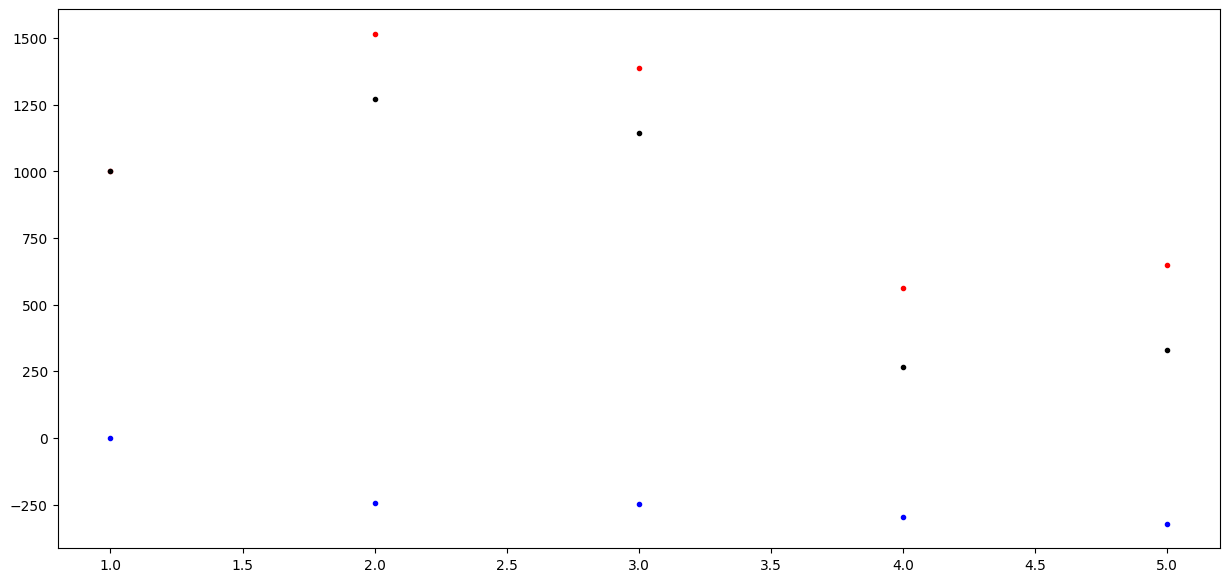

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')

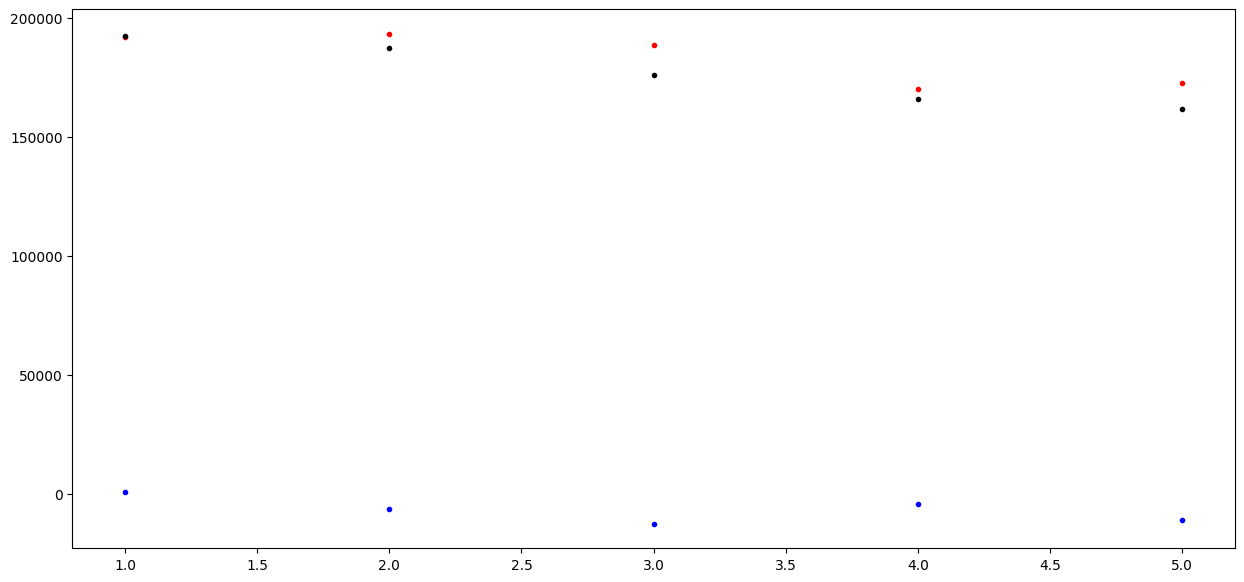

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_train],'k.')

In [ ]:
[i.fitness.values for i in hof.items]

[(191725.28127442498,),
 (187209.37665382808,),
 (175976.6652828827,),
 (165785.62153243626,),
 (161741.58411272374,)]

In [ ]:
# import os
# run_list = os.listdir("\home\khann\masters\results_run2_gen2\start_pop")
# run_list

In [ ]:
# cnt=0
# for dir in run_list:
#     if os.path.isdir(rf"\home\khann\masters\results_run2\{dir}"):
#         if cnt == 0:
#             df_tmp = pd.read_csv(rf"\home\khann\masters\results_run2\{dir}\run_info.csv")
#             df_tmp.drop('Unnamed: 0',axis=1, inplace=True)
#         else:
#             d = pd.read_csv(rf"\home\khann\masters\results_run2\{dir}\run_info.csv")
#             d.drop('Unnamed: 0',axis=1, inplace=True)
#             df_tmp = pd.concat([df_tmp, d], ignore_index=True, sort=False)
#         cnt+=1

In [40]:
from deap import gp
import pygraphviz as pgv

def replace_labels(labels,old,new):
    indices = [i for i, value in enumerate(list(labels.values())) if value == old]
    for i in indices:
        labels[i]=new
    return labels

def plot_tree(expr, name: str = "tree"):
    nodes, edges, labels = gp.graph(expr)
    labels = replace_labels(labels, 'or_','OR')
    labels = replace_labels(labels, 'and_','AND')
    labels = replace_labels(labels, 'gt','>')

    g = pgv.AGraph(strict=False, directed=False)
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.graph_attr["ranksep"] = "0.1"

    # Improve node and label spacing and change the node shape to "box"
    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]
        n.attr["fontsize"] = "10"  # Adjust font size for better readability
        n.attr["fontname"] = "Arial Bold" 
        n.attr["width"] = "0.5"    # Adjust node width
        n.attr["height"] = "0.05"   # Adjust node height
        n.attr["margin"] = "0.1"   # Add margin to prevent label overlap within nodes
        n.attr["shape"] = "box"    # Set the shape of the node to "box" to encapsulate in a block
        n.attr["style"] = "rounded" # Optional: Use rounded corners for the box
    for e in edges:
        edge = g.get_edge(e[0], e[1])
        edge.attr["arrowhead"] = "none"  # Remove arrows, making it a line
        edge.attr["penwidth"] = "1" 


    # Use a suitable layout program to avoid overlapping (dot is usually good for trees)
    g.layout(prog="dot")

    # Save the tree as an image
    g.draw(rf"./trees/{name}.png")



In [ ]:
# for i in range(len(best_sol_pop)):
#     plot_tree(best_sol_pop[i], name=f"run3_final/bs_{i}")

# Individual results

In [41]:
trading_strat_summary_table = []
for strat in [1,86]:
    val_train, mdd_train, ts_val_train, trade_row_train = trading_strat(individual= best_sol_pop[strat], df = df_train, pset = pset, ret_trade_row=True)
    val_test, mdd_test, ts_val_test, trade_row_test  = trading_strat(individual= best_sol_pop[strat], df = df_test, pset = pset, ret_trade_row=True)
    val_eth, mdd_eth, ts_val_eth, trade_row_eth  = trading_strat(individual= best_sol_pop[strat], df = eth_ts, pset = pset, ret_trade_row=True)

    trading_strat_summary_table.append({"Dataset":"Bitcoin Training","Buy-and-Hold Final Portfolio Value": train_df['Buy and Hold'].iloc[0] , "Final Portfolio value":val_train,"MDD":mdd_train, "Number of trades": len(trade_row_train)})
    trading_strat_summary_table.append({"Dataset":"Bitcoin Testing","Buy-and-Hold Final Portfolio Value":test_df['Buy and Hold'].iloc[0] , "Final Portfolio value":val_test,"MDD":mdd_test, "Number of trades": len(trade_row_test)})
    trading_strat_summary_table.append({"Dataset":"Ethereum", "Buy-and-Hold Final Portfolio Value":eth_df['Buy and Hold'].iloc[0] ,"Final Portfolio value":val_eth,"MDD":mdd_eth, "Number of trades": len(trade_row_eth)})

best_2_strat_df = pd.DataFrame(trading_strat_summary_table)
best_2_strat_df

,Dataset,Buy-and-Hold Final Portfolio Value,Final Portfolio value,MDD,Number of trades
0,Bitcoin Training,116918.977037,193214.984932,-6005.608278,19
1,Bitcoin Testing,1163.710097,1516.159471,-244.514260,9
2,Ethereum,4338.124866,4063.789329,-2320.594629,22
3,Bitcoin Training,116918.977037,108658.500313,-3565.559341,29
4,Bitcoin Testing,1163.710097,1320.564213,-137.711014,13
5,Ethereum,4338.124866,11320.915350,-2659.943078,37


In [42]:
best_2_strat_df.to_csv("Top_2_strat_details.csv")

In [43]:
28/(2024.5 - 2016)

3.2941176470588234

In [45]:
22/(2024.5-2017)

2.933333333333333

In [50]:
str(best_sol_pop[86])

"or_(gt('ma_open_8', 'ma_open_39'), gt('percentage_low_60', 'lag_open_36'))"

In [63]:
eth_ts["strat_86_comp1"] = eth_ts["ma_open_8"]>eth_ts["ma_open_39"]
eth_ts["strat_86_comp2"] = eth_ts["percentage_low_60"]>eth_ts["lag_open_36"]
eth_ts["strat_86 tot"] =  (eth_ts["strat_86_comp1"].apply(int) + eth_ts["strat_86_comp2"].apply(int)) > 0

comp1_per = sum(eth_ts["strat_86_comp1"])/sum(eth_ts["strat_86 tot"])*100
comp2_per = sum(eth_ts["strat_86_comp2"])/sum(eth_ts["strat_86 tot"])*100
print(comp1_per)
print(comp2_per)

100.0
9.35430463576159


In [61]:
(eth_ts["strat_86_comp1"].apply(int) + eth_ts["strat_86_comp2"].apply(int))>1

Date
2017-12-28 00:00:00+00:00     True
2017-12-29 00:00:00+00:00     True
2017-12-30 00:00:00+00:00    False
2017-12-31 00:00:00+00:00    False
2018-01-01 00:00:00+00:00    False
                             ...  
2024-06-25 00:00:00+00:00    False
2024-06-26 00:00:00+00:00    False
2024-06-27 00:00:00+00:00    False
2024-06-28 00:00:00+00:00    False
2024-06-29 00:00:00+00:00    False
Length: 2376, dtype: bool